# Porto Seguro

In [40]:
rus = pd.read_csv('../data/processed/submission_rus.csv')
ens = pd.read_csv('../data/processed/submission_ensemble.csv')
preds = rus.set_index('id').join(ens.set_index('id'), rsuffix='_ens')
(preds['predicted'] == preds['predicted_ens']).mean()

0.9368833498560166

In [13]:
# Libs to deal with tabular data
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 2000)

# Statistics
from scipy.stats import chi2_contingency
from scipy.stats.contingency import expected_freq

# Plotting packages
import seaborn as sns
sns.axes_style("darkgrid")
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Machine Learning
from xverse.transformer import WOE
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import recall_score, f1_score
from boruta import BorutaPy
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier

# Optimization
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_param_importances, plot_slice

# To display stuff in notebook
from IPython.display import display, Markdown

# Misc 
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import time
import os
import glob


In [14]:
def cramers_v(var1, var2):
    cont_freq = pd.crosstab(var1, var2).values
    n_obs = cont_freq.sum().sum()
    chi2_test = chi2_contingency(cont_freq)
    cramers_v = np.sqrt(chi2_test[0] / (n_obs * (min(cont_freq.shape) - 1)))
    return cramers_v

In [15]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')
feats = pd.read_csv('../data/raw/metadata.csv')

In [16]:
feats = feats[~feats['Variavel cod'].isin(['id', 'y'])]
feats['Variavel tipo'] = feats['Variavel tipo'].replace({
    'Qualitativo nominal': 'quali_nom',
    'Quantitativo discreto': 'quanti_dis',
    'Quantitativo continua': 'quanti_cont',
    'Qualitativo ordinal': 'quali_ord'
})
feat_type_dict = feats.groupby('Variavel tipo')['Variavel cod'].unique().to_dict()
feat_type_dict

{'quali_nom': array(['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8',
        'var9', 'var10', 'var11', 'var12', 'var13', 'var14', 'var15',
        'var16', 'var17', 'var18', 'var19', 'var20', 'var21', 'var22',
        'var23', 'var28', 'var29', 'var30', 'var31', 'var33', 'var34',
        'var35', 'var36', 'var37', 'var38', 'var39', 'var41'], dtype=object),
 'quali_ord': array(['var26', 'var32', 'var42', 'var43'], dtype=object),
 'quanti_cont': array(['var55', 'var56', 'var57', 'var58', 'var59', 'var60', 'var61',
        'var62', 'var63', 'var64', 'var65', 'var66'], dtype=object),
 'quanti_dis': array(['var24', 'var25', 'var27', 'var40', 'var44', 'var45', 'var46',
        'var47', 'var48', 'var49', 'var50', 'var51', 'var52', 'var53',
        'var54', 'var67', 'var68'], dtype=object)}

In [17]:
display(train.shape)
display(test.shape)

(14123, 70)

(21183, 69)

# Análise

- 68 variáveis 
- train 14123 linhas 
- test 21183 linhas
- 20% eventos
- Mesma quantidade de missing: (65,66), (26,58), (9,52), (15,16,17,18), (2,3)

In [19]:
train = train.replace({-999:np.nan})
test = test.replace({-999:np.nan})

nulos = pd.concat([train.isnull().mean(), test.isnull().mean()], axis=1, keys=['train', 'test'])
nulos['diff'] = (nulos['train'] - nulos['test']).abs()
nulos.sort_values('train', ascending=False)

,train,test,diff
var65,0.863627,0.861493,0.002134
var66,0.863627,0.861493,0.002134
var60,0.459109,0.461077,0.001968
var10,0.165616,0.165699,0.000083
var8,0.156766,0.153850,0.002916
var59,0.154500,0.153519,0.000980
var12,0.148977,0.151348,0.002371
var7,0.134178,0.132370,0.001808
var6,0.132479,0.130199,0.002280
var11,0.121716,0.122740,0.001024


## Quanti cont

- Algumas bem correlacionadas entre si, tanto positivo quanto negativo
- 8 tem nulos, 2 com a mesma quantidade de nulos
- vars não padronizadas, escaladas entre 0 e 1
- tem mesma média e desvio padrão no teste

In [20]:
train[feat_type_dict['quanti_cont']].sample(10)

,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66
12197,0.202875,NaN,NaN,NaN,NaN,NaN,0.263389,0.071525,0.002018,0.017603,NaN,NaN
3023,0.209268,0.183,0.731183,0.064506,0.167932,0.000283,0.381612,0.130293,0.883956,0.043497,NaN,NaN
5825,0.207759,0.879,0.053763,0.021311,0.178848,0.000000,0.687305,0.128649,0.632694,0.048339,NaN,NaN
7145,0.225596,0.150,0.833333,0.030531,0.246202,0.262241,0.572812,0.032908,0.958628,0.021257,0.141028,0.004221
8914,0.205496,0.023,1.000000,0.010548,0.222022,0.050337,0.236815,0.061196,0.945510,0.014231,NaN,NaN
4576,0.209376,0.230,0.451613,0.013852,0.080070,NaN,0.141466,0.030545,0.885974,0.010232,NaN,NaN
1192,0.203261,0.225,0.451613,0.020294,0.112199,0.182758,0.411711,0.054471,0.986882,0.016760,NaN,NaN
2152,0.211435,0.647,0.101075,0.540556,0.171758,0.127250,0.398127,0.110924,0.895055,0.034657,NaN,NaN
9118,0.207837,0.294,0.367742,0.015293,0.124173,0.084427,0.334343,0.022564,0.954591,0.012506,NaN,NaN
803,0.212952,0.145,0.833333,0.032424,0.490926,0.291957,0.118165,0.066432,0.747730,0.077873,NaN,NaN


In [22]:
train[feat_type_dict['quanti_cont']].isnull().corrwith(train['y'], method=cramers_v).sort_values(ascending=False)

var58    0.120931
var57    0.102259
var56    0.102090
var59    0.100958
var60    0.070085
var61    0.009498
var65    0.006599
var66    0.006599
var55         NaN
var62         NaN
var63         NaN
var64         NaN
dtype: float64

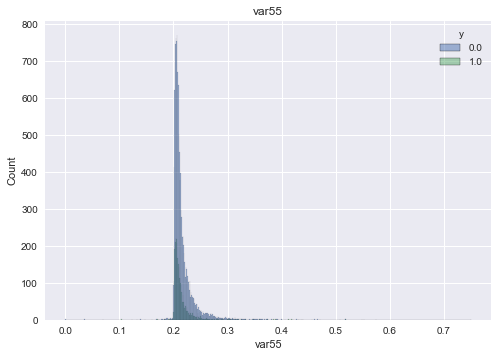

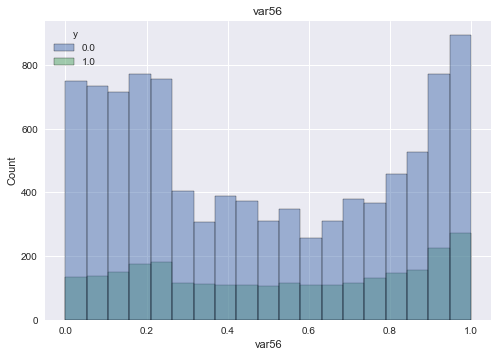

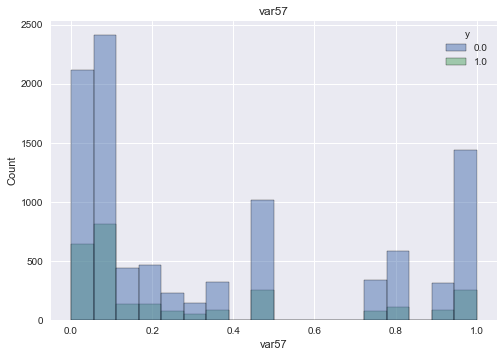

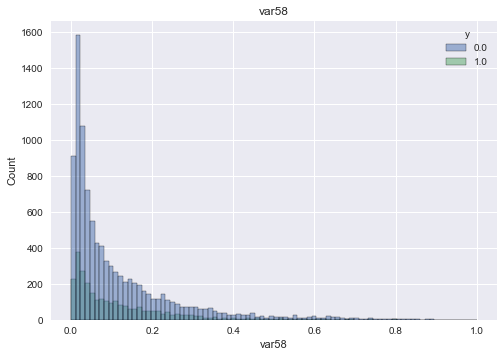

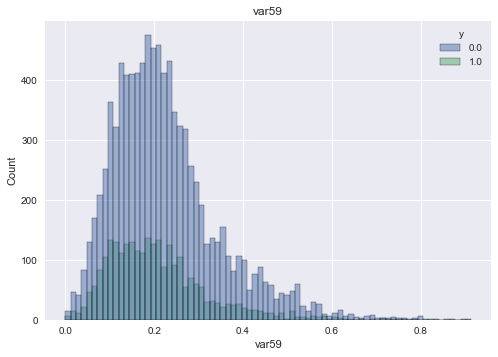

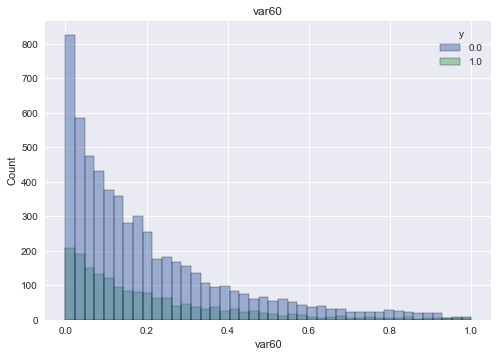

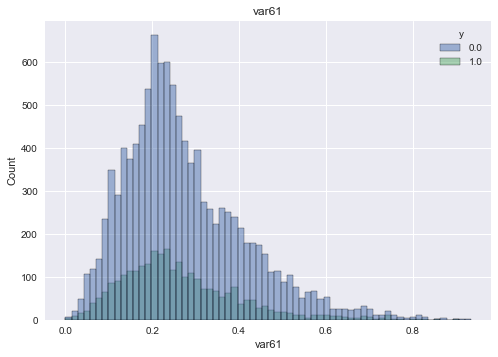

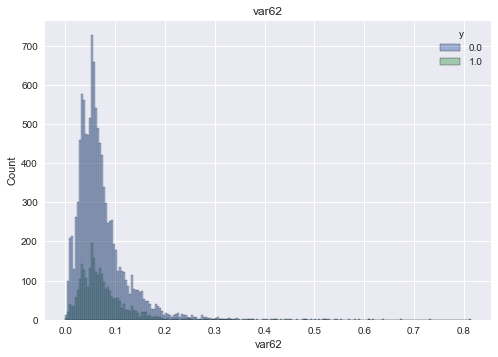

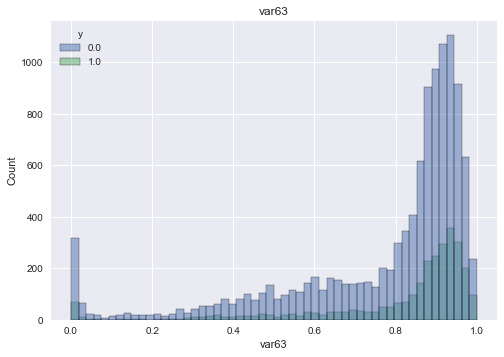

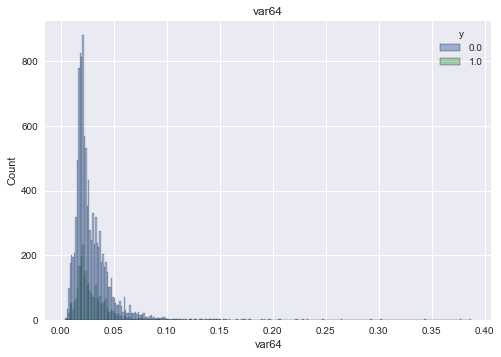

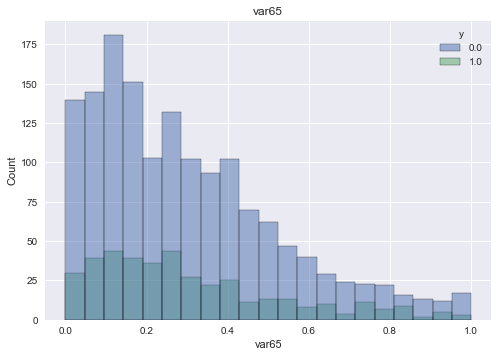

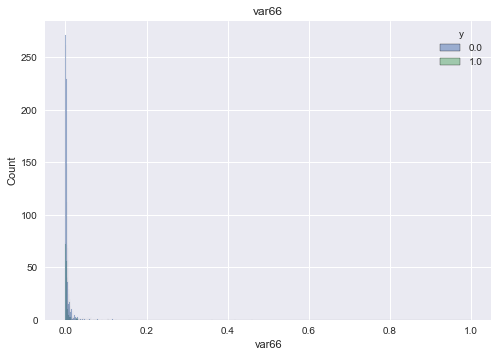

In [24]:
for col in feat_type_dict['quanti_cont']:
    sns.histplot(data=train, x=col, hue='y')
    plt.title(col)
    plt.show()

In [25]:
train[feat_type_dict['quanti_cont']].nunique()

var55    14003
var56      647
var57       20
var58     8093
var59     8813
var60     6776
var61     9435
var62    11613
var63      878
var64     3619
var65     1542
var66      180
dtype: int64

In [23]:
train[feat_type_dict['quanti_cont']].isnull().mean()

var55    0.000000
var56    0.112370
var57    0.112512
var58    0.111237
var59    0.154500
var60    0.459109
var61    0.024499
var62    0.000000
var63    0.000000
var64    0.000000
var65    0.863627
var66    0.863627
dtype: float64

<AxesSubplot:>

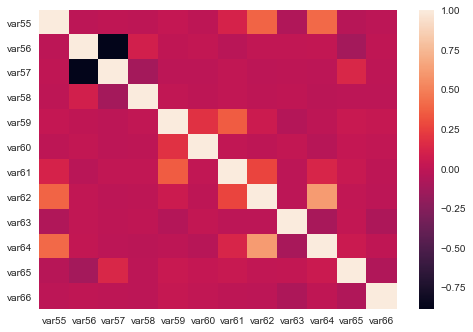

In [26]:
sns.heatmap(train[feat_type_dict['quanti_cont']].corr())

In [27]:
pd.concat([
    train[feat_type_dict['quanti_cont']].describe(),
    test[feat_type_dict['quanti_cont']].describe()
], axis=0, keys=['train', 'test'])

var55         var56         var57         var58  \
train count  14123.000000  12536.000000  12534.000000  12552.000000   
      mean       0.216031      0.490075      0.345775      0.116598   
      std        0.022642      0.325270      0.357000      0.138780   
      min        0.000000      0.000000      0.000000      0.000000   
      25%        0.205161      0.186000      0.078495      0.023393   
      50%        0.209465      0.453000      0.122581      0.062249   
      75%        0.218285      0.820000      0.731183      0.159355   
      max        0.750858      1.000000      1.000000      1.000000   
test  count  21183.000000  18823.000000  18821.000000  18795.000000   
      mean       0.216181      0.478490      0.361095      0.115029   
      std        0.024830      0.326247      0.363729      0.139124   
      min        0.128914      0.000000      0.000000      0.000000   
      25%        0.205040      0.177000      0.078495      0.022803   
      50%        0.209355      0.433000      0.150538      0.059374   
      75%        0.218251      0.809000      0.731183      0.155285   
      max        1.000000      1.000000      1.000000      0.968620   

                    var59         var60         var61         var62  \
train count  11941.000000   7639.000000  13777.000000  14123.000000   
      mean       0.221588      0.203008      0.270888      0.073086   
      std        0.120008      0.204867      0.138317      0.053963   
      min        0.000000      0.000000      0.000000      0.000000   
      25%        0.137193      0.051803      0.175993      0.040391   
      50%        0.202046      0.135267      0.243053      0.060265   
      75%        0.275253      0.286263      0.347631      0.088831   
      max        0.913773      1.000000      0.934994      0.814846   
test  count  17931.000000  11416.000000  20703.000000  21183.000000   
      mean       0.222856      0.201941      0.269854      0.073109   
      std        0.121631      0.207543      0.136865      0.055543   
      min        0.001559      0.000000      0.004547      0.000460   
      25%        0.137489      0.051048      0.175001      0.039955   
      50%        0.203198      0.133296      0.243253      0.060225   
      75%        0.276462      0.282056      0.347102      0.088890   
      max        1.000000      0.993411      1.000000      1.000000   

                    var63         var64        var65        var66  
train count  14123.000000  14123.000000  1926.000000  1926.000000  
      mean       0.779221      0.028778     0.301400     0.007116  
      std        0.234068      0.018681     0.227254     0.029982  
      min        0.000000      0.004267     0.000000     0.000000  
      25%        0.706357      0.018357     0.121432     0.002010  
      50%        0.877901      0.023480     0.251427     0.003199  
      75%        0.930373      0.034581     0.425166     0.006030  
      max        1.000000      0.387386     1.000000     1.000000  
test  count  21183.000000  21183.000000  2934.000000  2934.000000  
      mean       0.779848      0.028984     0.302586     0.006880  
      std        0.233090      0.020150     0.221812     0.018943  
      min        0.000000      0.000000     0.000000     0.000000  
      25%        0.716448      0.018408     0.128221     0.002010  
      50%        0.877901      0.023480     0.254976     0.003015  
      75%        0.929364      0.034798     0.433807     0.006030  
      max        1.000000      1.000000     0.998457     0.392630

In [28]:
train[feat_type_dict['quanti_cont']].corrwith(train['y'], method='spearman').sort_values()

var57   -0.067250
var59   -0.062969
var55   -0.049646
var61   -0.032370
var66   -0.011143
var60    0.004051
var65    0.011113
var64    0.033174
var62    0.035860
var58    0.036724
var56    0.066562
var63    0.082397
dtype: float64

## Quanti dis

- 15 sao discretas, 2 parecem continuas
- mesmas distribuicoes no teste
- o teste tem alguns valores maximos que não estão no treino

In [ ]:
train[feat_type_dict['quanti_dis']].sample(10)

In [ ]:
train[feat_type_dict['quanti_dis']].isnull().mean()

In [ ]:
train[feat_type_dict['quanti_dis']].nunique()

In [ ]:
for col in train[feat_type_dict['quanti_dis']]:
    sns.countplot(data=train, x= col, hue='y')
    plt.title(col)
    plt.show()

In [ ]:
pd.concat([
    train[feat_type_dict['quanti_dis']].describe(),
    test[feat_type_dict['quanti_dis']].describe()
], axis=0, keys=['train', 'test'])

In [ ]:
train[feat_type_dict['quanti_dis']].corrwith(train['y'], method=cramers_v).sort_values(ascending=False)

## Quali nom

- treino e test similares
- algumas variaveis nao parecem qualitativas nominais.
- a % de missing maximo eh de 15%
- a maioria das variaveis tem muitas categorias
- 2 variaveis tem pouquissimos valores iguais (muitos niveis)

In [ ]:
train[feat_type_dict['quali_nom']].sample(10)

In [ ]:
train[feat_type_dict['quali_nom']].isnull().mean().sort_values(ascending=False)

In [ ]:
train[feat_type_dict['quali_nom']].nunique()

In [ ]:
train[feat_type_dict['quali_nom']].nunique()

In [ ]:
for col in feat_type_dict['quali_nom']:
    sns.histplot(data=train, x=col, hue='y')
    plt.title(col)
    plt.show()

In [ ]:
pd.concat([
    train[feat_type_dict['quali_nom']].describe(),
    test[feat_type_dict['quali_nom']].describe()
], axis=0, keys=['train', 'test'])

In [ ]:
train[feat_type_dict['quali_nom']].corrwith(train['y'], method='spearman').sort_values(ascending=False)

## Quali ord

In [ ]:
train[feat_type_dict['quali_ord']].sample(10)

In [ ]:
train[feat_type_dict['quali_ord']].isnull().mean()

In [ ]:
train[feat_type_dict['quali_ord']].nunique()

In [ ]:
for col in train[feat_type_dict['quali_ord']]:
    sns.countplot(data=train, x= col, hue='y')
    plt.title(col)
    plt.show()

In [ ]:
pd.concat([
    train[feat_type_dict['quali_ord']].describe(),
    test[feat_type_dict['quali_ord']].describe()
], axis=0, keys=['train', 'test'])

In [ ]:
train[feat_type_dict['quali_ord']].corrwith(train['y'], method=cramers_v).sort_values(ascending=False)